<a href="https://colab.research.google.com/github/maulikb/lane-detection-using-conventional-image-processing/blob/main/Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import glob

%matplotlib inline



# Intrinsic And Extrinsic Calculation Using Camera Calibration

In [ ]:

def camera_calibration(images, nx, ny):
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist

def undistort(img, mtx, dist):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted


# Thresholding Using Sobel Kernel



In [ ]:

def color_gradient_threshold(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Perspective And Inverse-Perspective Transformation

In [ ]:
def perspective_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


# Fit Polynomial On Detected Pixels


In [ ]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = binary_warped.shape[0] // nwindows
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty



def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty

def measure_curvature_pixels(left_fit, right_fit, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return left_curverad, right_curverad


# Draw Lane On Original

In [ ]:

def draw_lane(original_img, binary_warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return result

# Process Single Image For Lane Pipeline

In [ ]:
def process_frame(frame, mtx, dist):
    undistorted = undistort(frame, mtx, dist)

    # Apply color and gradient thresholding
    combined_binary = color_gradient_threshold(undistorted)  # Implement this function to apply thresholding

    # Define perspective transform source and destination points
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])

    # Apply perspective transform to rectify binary image ("birds-eye view")
    binary_warped, M, Minv = perspective_transform(combined_binary, src, dst)

    # Detect lane pixels and fit to find the lane boundary
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

    # Determine the curvature of the lane
    left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit, ploty)

    # Draw lane on original image
    result = draw_lane(undistorted, binary_warped, left_fitx, right_fitx, ploty, Minv)

    return result

# Upload Images For Calibration Matrix And Distortion Parameter Calculation


In [ ]:
# Upload calibration images
uploaded = files.upload()

# Define the number of corners in the chessboard
nx = 9  # Number of inside corners in x
ny = 6  # Number of inside corners in y

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (6,5,0)
objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Read calibration images
images = glob.glob('*.jpg')

# Iterate through calibration images
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save calibration parameters
np.savez('calibration_params.npz', mtx=mtx, dist=dist)

# Print calibration parameters
print("Camera Matrix (mtx):")
print(mtx)
print("\nDistortion Coefficients (dist):")
print(dist)
# Load calibration parameters
calibration_data = np.load('calibration_params.npz')
mtx = calibration_data['mtx']
dist = calibration_data['dist']



Saving calibration1.jpg to calibration1 (2).jpg
Saving calibration2.jpg to calibration2 (2).jpg
Saving calibration3.jpg to calibration3 (2).jpg
Saving calibration4.jpg to calibration4 (2).jpg
Saving calibration5.jpg to calibration5 (2).jpg
Saving calibration6.jpg to calibration6 (2).jpg
Saving calibration7.jpg to calibration7 (2).jpg
Saving calibration8.jpg to calibration8 (2).jpg
Saving calibration9.jpg to calibration9 (2).jpg
Saving calibration10.jpg to calibration10 (2).jpg
Saving calibration11.jpg to calibration11 (2).jpg
Saving calibration12.jpg to calibration12 (2).jpg
Saving calibration13.jpg to calibration13 (2).jpg
Saving calibration14.jpg to calibration14 (2).jpg
Saving calibration15.jpg to calibration15 (2).jpg
Saving calibration16.jpg to calibration16 (2).jpg
Saving calibration17.jpg to calibration17 (2).jpg
Saving calibration18.jpg to calibration18 (2).jpg
Saving calibration19.jpg to calibration19 (2).jpg
Saving calibration20.jpg to calibration20 (2).jpg
Camera Matrix (mtx

# Do Testing On Uploaded Image And Get Each Transformed Image

Saving image003.jpg to image003 (1).jpg


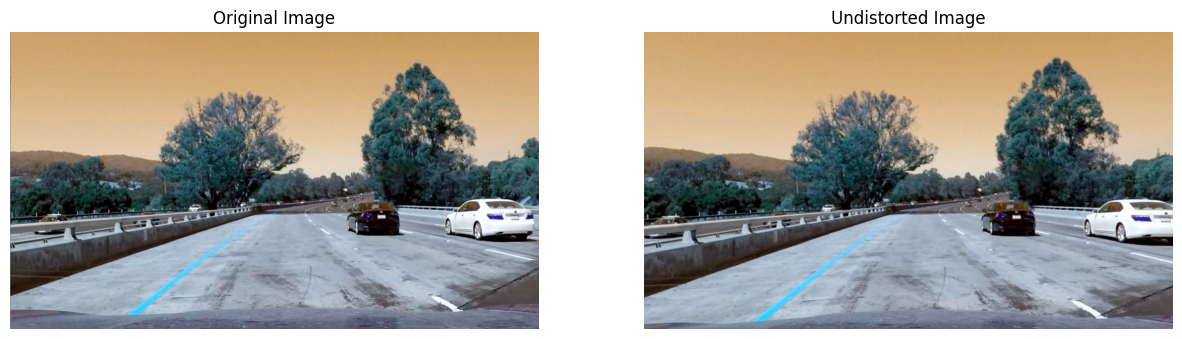

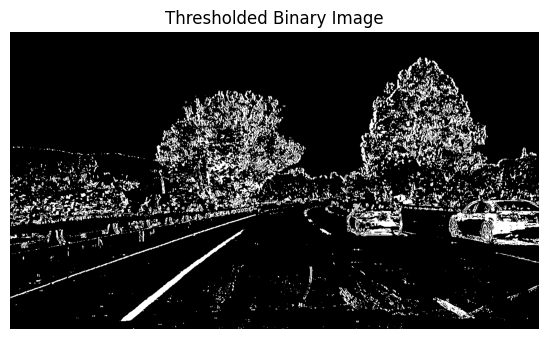

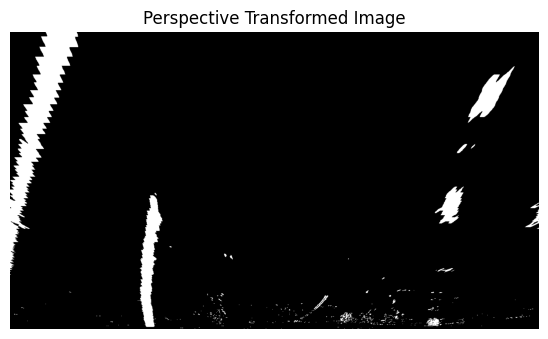

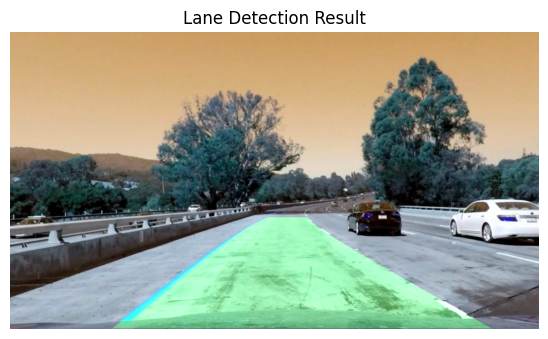

In [ ]:

# Upload a test image
uploaded = files.upload()

# Get the filename of the uploaded image
filename = list(uploaded.keys())[0]

# Load the uploaded image
test_img = cv2.imread(filename)

# Convert the image to RGB (OpenCV loads images in BGR format)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

def display_images(images, titles=None, cols=2, figsize=(15, 10)):
    """
    Display a list of images with their titles.
    """
    num_images = len(images)
    rows = int(np.ceil(num_images / cols))  # Cast to integer
    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()


def process_frame_with_visualization(frame, mtx, dist):
    # Perform camera calibration
    undistorted = undistort(frame, mtx, dist)
    display_images([frame, undistorted], titles=['Original Image', 'Undistorted Image'])

    # Apply color and gradient thresholding
    combined_binary = color_gradient_threshold(undistorted)
    display_images([combined_binary], titles=['Thresholded Binary Image'])

    # Define perspective transform source and destination points
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])

    # Apply perspective transform
    binary_warped, M, Minv = perspective_transform(combined_binary, src, dst)
    display_images([binary_warped], titles=['Perspective Transformed Image'])

    # Detect lane pixels and fit polynomial
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

    # Determine the curvature of the lane
    left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit, ploty)

    # Draw lane on original image
    result = draw_lane(undistorted, binary_warped, left_fitx, right_fitx, ploty, Minv)
    display_images([result], titles=['Lane Detection Result'])

    return result

# Process the frame with visualization
result_with_visualization = process_frame_with_visualization(test_img, mtx, dist)